# Using unsupervised machine learning to profile prospects
#### A KMeans and GMM clustering comparison 

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pylab import rcParams

### **Data Loading**

In [2]:
year_start = list(range(2022,2025))
year_end = list(range(23,26))
gw_list = list(range(1,39))

In [3]:
all_data = pd.DataFrame()
for start, end in zip(year_start, year_end):
    for gw_n in gw_list:
        url = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{start}-{end}/gws/gw{gw_n}.csv"
        df = pd.read_csv(url)
        all_data = pd.concat([all_data, df], axis = 0, ignore_index = True)

/var/folders/4k/z4jxzwl963bfwxwc9zm2tcph0000gp/T/ipykernel_57291/3563785761.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df], axis = 0, ignore_index = True)


In [4]:
all_data_filtered = all_data[['kickoff_time', 'name', 'position', 'team', 'opponent_team', 'minutes', 'was_home', 
                              'total_points', 'xP',  'bonus', 'bps',
                              'goals_scored', 'assists', 'expected_assists','expected_goal_involvements', 'expected_goals',
                                 'creativity', 'influence', 'threat',
                               'goals_conceded','expected_goals_conceded', 'own_goals', 'penalties_missed', 'penalties_saved', 'saves',
                              'clean_sheets', 'yellow_cards', 'red_cards',
                              'fixture', 'ict_index',
                               'round',  'selected', 'starts', 'team_a_score', 'team_h_score',
                                'transfers_balance', 'transfers_in', 'transfers_out', 'value']]
all_data_filtered.head(5)

,kickoff_time,name,position,team,opponent_team,minutes,was_home,total_points,xP,bonus,...,ict_index,round,selected,starts,team_a_score,team_h_score,transfers_balance,transfers_in,transfers_out,value
0,2022-08-06T14:00:00Z,Nathan Redmond,MID,Southampton,18,1,False,1,1.5,0,...,0.0,1,5871,0,1,4,0,0,0,55
1,2022-08-06T14:00:00Z,Junior Stanislas,MID,Bournemouth,2,1,True,1,1.1,0,...,0.0,1,9491,0,0,2,0,0,0,50
2,2022-08-06T16:30:00Z,Armando Broja,FWD,Chelsea,8,15,False,1,2.0,0,...,2.5,1,124903,0,1,0,0,0,0,55
3,2022-08-06T14:00:00Z,Fabian Schär,DEF,Newcastle,16,90,True,15,2.4,3,...,10.6,1,40132,0,0,2,0,0,0,45
4,2022-08-07T13:00:00Z,Jonny Evans,DEF,Leicester,4,90,True,1,1.9,0,...,1.5,1,24256,0,2,2,0,0,0,45


In [6]:
# Remove the rows where players didnot play
# Change opponent team to categorical
all_data_filtered = all_data_filtered[all_data_filtered['minutes'] != 0].reset_index()
all_data_filtered['opponent_team'] = 'team_'+all_data_filtered['opponent_team'].astype(str)

### **Data Exploration**

In [7]:
%matplotlib inline

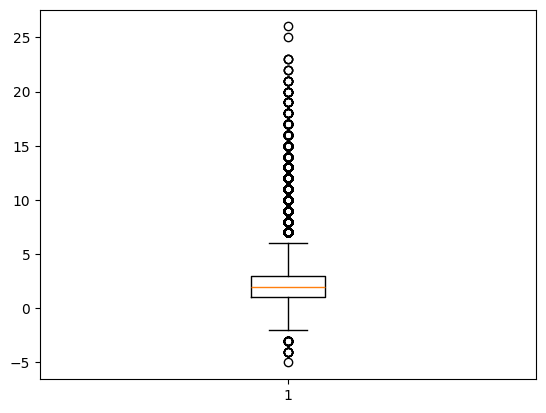

In [8]:
# Points distribution 
plt.boxplot(all_data_filtered['total_points'])
plt.show()

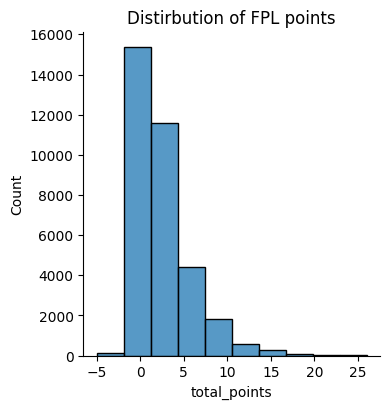

In [9]:
# Distribution of points metric

sns.displot(data = all_data_filtered['total_points'], bins=10, height=4, aspect=1)
plt.title('Distirbution of FPL points')
plt.show()

# heavily scewed

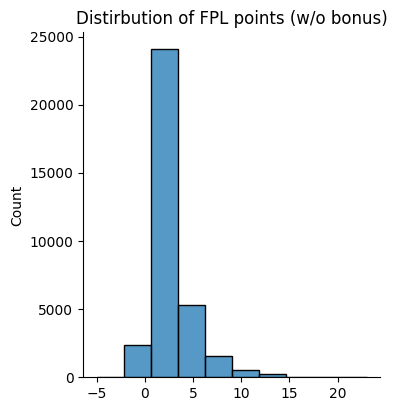

In [10]:
# Distribution of points without bonus points

df_x = all_data_filtered['total_points']-all_data_filtered['bonus']
sns.displot(data = df_x, bins=10, height=4, aspect=1)
plt.title('Distirbution of FPL points (w/o bonus)')
plt.show()

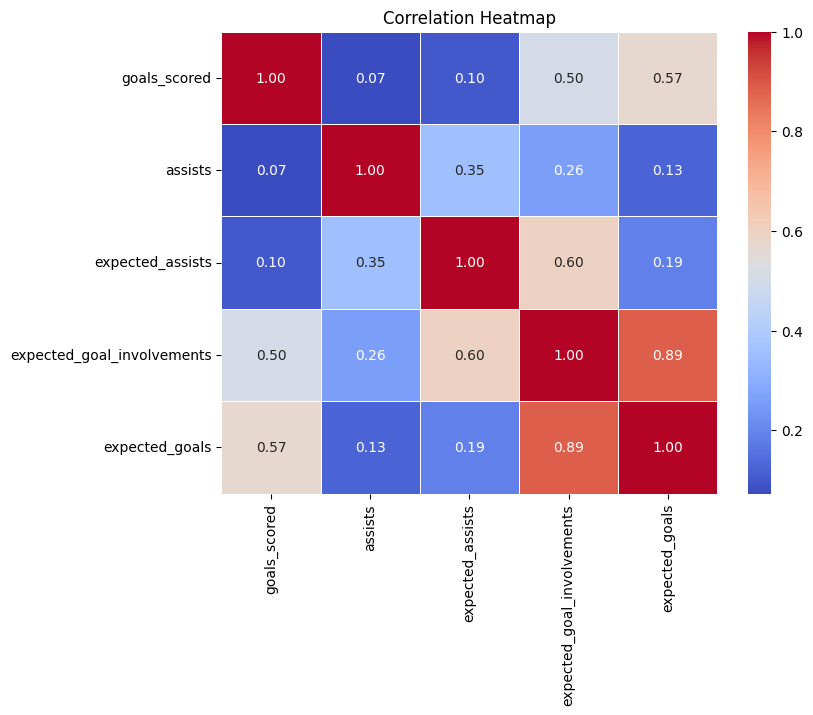

In [11]:
# Correlation between goal/assist metrics
correlation_matrix = all_data_filtered[['goals_scored', 'assists', 'expected_assists','expected_goal_involvements', 'expected_goals']].corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# --expected_goal_involvement can be dropped

In [12]:
# ICT
mask = all_data_filtered['minutes'] > 0
all_data_filtered[mask][['position','creativity','influence','threat']].groupby('position').median()

,creativity,influence,threat
position,,,
DEF,1.8,14.6,2.0
FWD,3.0,4.0,13.0
GK,0.0,22.0,0.0
MID,9.9,8.0,5.0


In [13]:
mask = all_data_filtered['minutes'] > 0
all_data_filtered[mask][['position','creativity','influence','threat']].groupby('position').mean()

,creativity,influence,threat
position,,,
DEF,7.523111,15.945537,5.149921
FWD,8.433437,13.149535,20.039828
GK,0.327029,24.224611,0.014249
MID,13.575372,13.129731,11.349451


# Prediction

### **Feature Engineering**

In [17]:
# Initiate the final prepped dataframe
df_prep = pd.DataFrame()

In [18]:
# Add formated date and name
df_prep['date'] = pd.to_datetime(all_data_filtered['kickoff_time'].str[:10])
df_prep['name'] = all_data_filtered['name']
df_prep.head()

,date,name
0,2022-08-06,Nathan Redmond
1,2022-08-06,Junior Stanislas
2,2022-08-06,Armando Broja
3,2022-08-06,Fabian Schär
4,2022-08-07,Jonny Evans


In [19]:
# Add all the numerical variables
df_prep = pd.concat([df_prep, all_data_filtered[['was_home', 'total_points', 'xP',  'bonus', 'bps',
                                              'goals_scored', 'assists', 'expected_assists','expected_goals',
                                                 'creativity', 'influence', 'threat']]], axis = 1)

In [20]:
# Sort data by date and player
df_prep = df_prep.sort_values(by = ['name','date'])

In [21]:
# Calculate moving averages of performance metrics
'''
Using the lagging features to enable prediction and capture player form in the past games
Using lagging expected metrics to inform model what the expectations have been for the player and if they align with the expectations
'''
from pandasql import sqldf
pysqldf_x = lambda q: sqldf(q, globals())

query_1 = "SELECT *,\
            SUM(goals_scored) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as goal_scored_ms,\
            SUM(assists) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as assists_ms,\
            SUM(expected_goals) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as expected_goals_ms,\
            SUM(expected_assists) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as expected_assists_ms,\
            AVG(creativity) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as creativity_ma,\
            AVG(influence) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as influence_ma,\
            AVG(threat) OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as threat_ma,\
            rank() OVER(PARTITION BY name ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as rank_num\
            FROM df_prep"

result = pysqldf_x(query_1)
df_prep_upd = pd.DataFrame(result)
df_prep_upd['date'] = pd.to_datetime(df_prep_upd['date']) #changing date column type

# Shift aggregated metrics by one to inform next prediction
df_prep_upd['goal_scored_ms'] = df_prep_upd['goal_scored_ms'].shift(1)
df_prep_upd['assists_ms'] = df_prep_upd['assists_ms'].shift(1)
df_prep_upd['expected_goals_ms'] = df_prep_upd['expected_goals_ms'].shift(1)
df_prep_upd['expected_assists_ms'] = df_prep_upd['expected_assists_ms'].shift(1)
df_prep_upd['creativity_ma'] = df_prep_upd['creativity_ma'].shift(1)
df_prep_upd['influence_ma'] = df_prep_upd['influence_ma'].shift(1)
df_prep_upd['threat_ma'] = df_prep_upd['threat_ma'].shift(1)

In [22]:
# quick check
df_prep_upd[df_prep_upd['name']=='Erling Haaland'].iloc[1:8,-15:-1]

,goals_scored,assists,expected_assists,expected_goals,creativity,influence,threat,goal_scored_ms,assists_ms,expected_goals_ms,expected_assists_ms,creativity_ma,influence_ma,threat_ma
10151,0,1,0.0,0.0,13.3,18.2,23.0,2.0,0.0,0.0,0.0,4.800000,62.600000,73.000000
10152,1,0,0.0,0.0,11.9,43.0,70.0,2.0,1.0,0.0,0.0,9.050000,40.400000,48.000000
10153,3,0,0.0,0.0,1.3,87.2,105.0,3.0,1.0,0.0,0.0,10.000000,41.266667,55.333333
10154,3,0,0.0,0.0,0.8,97.2,91.0,4.0,1.0,0.0,0.0,8.833333,49.466667,66.000000
10155,1,0,0.0,0.0,14.8,41.6,79.0,7.0,0.0,0.0,0.0,4.666667,75.800000,88.666667
10156,1,0,0.0,0.0,3.4,37.6,22.0,7.0,0.0,0.0,0.0,5.633333,75.333333,91.666667
10157,3,2,0.0,0.0,45.5,135.2,124.0,5.0,0.0,0.0,0.0,6.333333,58.800000,64.000000


In [23]:
# Remove the starting 3 rows for each player -- no lag metrics available

df_prep_upd = df_prep_upd[df_prep_upd['rank_num']>3]
df_prep_upd.isna().sum().sum()

np.int64(0)

In [24]:
# Creating an impact class based on the points

df_prep_upd.loc[:,'impact'] = df_prep_upd.loc[:,'total_points'].apply(lambda pt: 0 if pt <= 3 else (1 if pt < 7 else 2))

### **Applying a model**

**Why Classification?** 
The points distribution is heavily skewed and does not represent a normal distribution. Clustering will allow for bucketing players into different categories enabling targeting decisions, without assuming normality.

**Why Random Forest?**
1. It takes care of overfitting by bootstrapping data. As opposed to decision tree or bagged decision trees it uses randomization to take 
care of overfitting.
2. A popular classification model
3. High interpretability -- can be visualized to share with stakeholders what exactly is happening under the hood -- a series of if/else
4. Shows feature importance -- helps in identifying top features affecting our outcome


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [26]:
# Generate feature set
df_features = df_prep_upd.drop(['date', 'name', 'goals_scored', 'assists', 'expected_assists', 'expected_goals', 
                                'creativity', 'influence', 'threat','bps','bonus', 'total_points', 'xP',
                               'rank_num', 'impact'], axis=1)
print(df_features.shape)
print(df_prep_upd['impact'].shape)

(31577, 8)
(31577,)


In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_features, df_prep_upd['impact'], random_state = 23)

In [28]:
# Initiate classification model
reg = RandomForestClassifier(n_estimators = 1000, random_state = 23)
reg.fit(X_train, y_train)
score = reg.score(X_test, y_test)
score

0.7650411652944902

In [29]:
# Check Feature Impotances
importances = pd.DataFrame({'feature':X_train.columns,'importance (%)':np.round(reg.feature_importances_*100,1)})
importances = importances.sort_values('importance (%)',ascending=False).reset_index(drop = True)
importances

,feature,importance (%)
0,influence_ma,26.6
1,creativity_ma,22.0
2,threat_ma,16.1
3,expected_assists_ms,15.6
4,expected_goals_ms,13.7
5,assists_ms,2.6
6,goal_scored_ms,1.8
7,was_home,1.7


# Clustering

In [31]:
#KMeans
from sklearn.cluster import KMeans

In [36]:
# Pick the rows when players played, and where at least one of the ICT is non-zero

mask = (all_data_filtered['minutes'] > 0) & ((all_data_filtered['creativity'] != 0) | (all_data_filtered['influence'] != 0) | (all_data_filtered['threat'] != 0))
df_prep = all_data_filtered[mask][['name','position','minutes','creativity','influence','threat']].reset_index(drop = True)

In [37]:
# Get the data on player level
# Usign weighted averages by minutes played

player_ict = df_prep.groupby(['name','position']).apply(
    lambda x: pd.Series({
        'creativity': (x['creativity'] * x['minutes']).sum() / x['minutes'].sum(),
        'influence': (x['influence'] * x['minutes']).sum() / x['minutes'].sum(),
        'threat': (x['threat'] * x['minutes']).sum() / x['minutes'].sum()
    })
).reset_index()

/var/folders/4k/z4jxzwl963bfwxwc9zm2tcph0000gp/T/ipykernel_57291/3776712165.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_ict = df_prep.groupby(['name','position']).apply(


In [38]:
X = player_ict.loc[:, ['creativity','influence','threat']].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(966, 3)

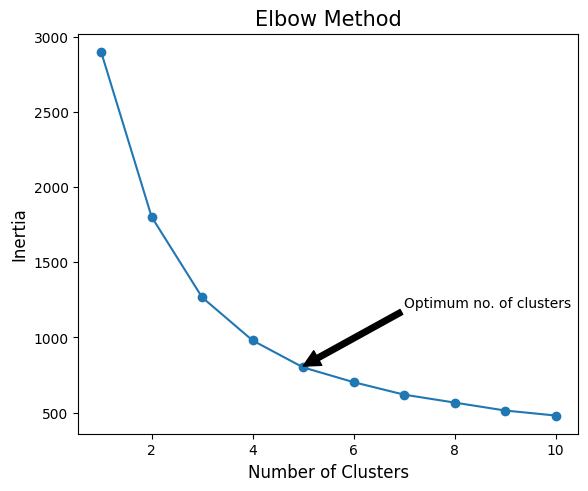

In [39]:
# Optimizing Clusters
wcss = []
for k in range(1, 11):
    kmeans_x = KMeans(n_clusters=k, random_state=1).fit(X)
    wcss.append(kmeans_x.inertia_)


rcParams['figure.figsize'] = 5,4

fig = plt.figure()
ax = fig.add_axes([.1,.1,1,1])

plt.plot(range(1, 11), wcss, marker='o')

ax.set_title('Elbow Method', fontsize=15)

ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Inertia', fontsize=12)
ax.annotate('Optimum no. of clusters', xy = (5,810), xytext = (7,1200), arrowprops = dict(facecolor = 'black'))
plt.show()

In [40]:
# Picking 5 as the optimum clusters
# Main model
kmeans = KMeans(n_clusters = 5, random_state = 1)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [41]:
labels_df = pd.DataFrame(labels, columns=['kmeans_label'])
result_df = pd.concat([player_ict, labels_df], axis=1)
result_df = result_df.sort_values(by = ['name','position'])
result_df.head()

,name,position,creativity,influence,threat,kmeans_label
0,Aaron Cresswell,DEF,21.377369,14.775103,2.384932,1
1,Aaron Hickey,DEF,4.736939,9.441390,4.212027,0
2,Aaron Ramsdale,GK,0.001370,24.865753,0.000000,4
3,Aaron Ramsey,MID,3.175096,5.233333,6.306513,0
4,Aaron Wan-Bissaka,DEF,13.232237,20.712901,5.254687,3


In [45]:
# Calculating values and points

mask = (all_data_filtered['minutes'] > 0) & ((all_data_filtered['creativity'] != 0) | (all_data_filtered['influence'] != 0) | (all_data_filtered['threat'] != 0))
points_df = all_data_filtered[mask][['name','position','total_points','minutes','value']].reset_index(drop = True)

In [46]:
points_df = points_df.groupby(['name','position']).agg(total_points = ('total_points','sum'),
                                                      total_minutes = ('minutes', 'sum'),
                                                      avg_value_in_pounds = ('value','mean')).reset_index()
points_df['avg_value_in_pounds'] = (points_df['avg_value_in_pounds'].astype(float)/10).round(1)
points_df = points_df.sort_values(by = ['name','position'])
points_df.head(5)

,name,position,total_points,total_minutes,avg_value_in_pounds
0,Aaron Cresswell,DEF,116,3398,4.4
1,Aaron Hickey,DEF,73,2561,4.8
2,Aaron Ramsdale,GK,254,6570,4.7
3,Aaron Ramsey,MID,18,522,5.0
4,Aaron Wan-Bissaka,DEF,231,6294,4.4


In [47]:
# Adding points per pound and points per minute metric

all_player_df = pd.concat([result_df, points_df[['total_points', 'total_minutes', 'avg_value_in_pounds']]], axis = 1)
all_player_df.loc[:,'points_per_minute'] = (all_player_df.loc[:,'total_points']/all_player_df.loc[:,'total_minutes']).astype(float).round(2)
all_player_df.loc[:,'points_per_pound'] = (all_player_df.loc[:,'total_points']/all_player_df.loc[:,'avg_value_in_pounds']).astype(float).round(1)
all_player_df.head(5)

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
0,Aaron Cresswell,DEF,21.377369,14.775103,2.384932,1,116,3398,4.4,0.03,26.4
1,Aaron Hickey,DEF,4.736939,9.441390,4.212027,0,73,2561,4.8,0.03,15.2
2,Aaron Ramsdale,GK,0.001370,24.865753,0.000000,4,254,6570,4.7,0.04,54.0
3,Aaron Ramsey,MID,3.175096,5.233333,6.306513,0,18,522,5.0,0.03,3.6
4,Aaron Wan-Bissaka,DEF,13.232237,20.712901,5.254687,3,231,6294,4.4,0.04,52.5


### **Evaluation**

In [48]:
#Cluster 0
all_player_df[all_player_df['kmeans_label'] == 0].sort_values(by = 'total_points', ascending = False).head(5)

# -- low performers

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
698,Nathaniel Clyne,DEF,5.882285,10.488605,0.856190,0,113,3449,4.4,0.03,25.7
1,Aaron Hickey,DEF,4.736939,9.441390,4.212027,0,73,2561,4.8,0.03,15.2
72,Armando Broja,FWD,6.269182,5.698000,11.558182,0,63,1100,5.1,0.06,12.4
70,Archie Gray,MID,3.463257,12.437943,0.771429,0,45,1750,4.7,0.03,9.6
109,Boubacar Traoré,MID,5.551868,7.803735,1.685908,0,38,1178,4.4,0.03,8.6


In [49]:
#Cluster 1 
all_player_df[all_player_df['kmeans_label'] == 1].sort_values(by = 'total_points', ascending = False).head(5)

# -- (Play Makers) -- Highest on Creativity, and high on influence and theart

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
122,Bukayo Saka,MID,35.015187,28.571583,35.731789,1,549,7770,9.0,0.07,61.0
612,Martin Ødegaard,MID,36.661142,24.374755,22.065471,1,511,8477,7.8,0.06,65.5
117,Bruno Borges Fernandes,MID,43.731048,29.317619,21.495048,1,495,9189,8.8,0.05,56.2
170,Cole Palmer,MID,32.841247,33.324350,29.780355,1,475,6078,7.7,0.08,61.7
758,Phil Foden,MID,32.527883,27.550039,29.243841,1,475,6373,8.3,0.07,57.2


In [50]:
#Cluster 2
# all_player_df[(all_player_df['kmeans_label'] == 2) & (all_player_df['total_minutes']>4000)].sort_values(by = 'points_per_minute', ascending = False).head(10)
all_player_df[(all_player_df['kmeans_label'] == 2)].sort_values(by = 'total_points', ascending = False).head(5)

# -- (Game Changers) -- high on influence and threat

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
669,Mohamed Salah,MID,28.637188,35.369270,49.673476,2,789,9105,13.1,0.09,60.2
269,Erling Haaland,FWD,11.870606,35.519886,51.554245,2,670,8056,13.7,0.08,48.9
729,Ollie Watkins,FWD,12.850440,25.060899,36.893156,2,580,8854,8.3,0.07,69.9
415,Jarrod Bowen,MID,18.164481,23.395716,31.851707,2,519,9198,7.7,0.06,67.4
856,Son Heung-min,MID,25.862267,23.038583,28.347199,2,481,7765,10.4,0.06,46.2


In [52]:
#Cluster 3 
all_player_df[all_player_df['kmeans_label'] == 3].sort_values(by = 'total_points', ascending = False).head(5)

# --(Team players) -- moderate on all attributes. are selected in the line-up often

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
99,Benjamin White,DEF,14.632946,19.504661,5.599860,3,381,7145,5.4,0.05,70.6
906,Tyrick Mitchell,DEF,11.345332,17.023271,4.889145,3,333,9093,4.6,0.04,72.4
227,Diogo Dalot Teixeira,DEF,16.025157,18.804624,8.092486,3,305,7958,4.9,0.04,62.2
66,Antonee Robinson,DEF,15.818951,21.654968,4.801071,3,301,9340,4.6,0.03,65.4
916,Vitalii Mykolenko,DEF,10.634619,17.768400,4.681908,3,297,8114,4.4,0.04,67.5


In [53]:
#Cluster 4
all_player_df[all_player_df['kmeans_label'] == 4].sort_values(by = 'total_points', ascending = False).head(5)
#-- (Influencers) - Highest on Influence (Leaders)

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
209,David Raya Martin,GK,0.293333,21.845714,0.038095,4,435,9450,5.1,0.05,85.3
462,Jordan Pickford,GK,0.781081,26.949550,0.000000,4,429,9990,4.7,0.04,91.3
936,William Saliba,DEF,4.057009,19.217151,3.752535,4,411,8874,5.6,0.05,73.4
299,Gabriel dos Santos Magalhães,DEF,4.721504,20.112999,10.751605,4,406,8724,5.4,0.05,75.2
915,Virgil van Dijk,DEF,4.846146,24.899807,10.953757,4,387,9342,6.4,0.04,60.5


In [54]:
mask = (all_player_df['name'] == 'Trent Alexander-Arnold') | (all_player_df['name'] == 'Reece James') | (all_player_df['name'] == 'João Cancelo')
all_player_df[mask]

,name,position,creativity,influence,threat,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
478,João Cancelo,DEF,16.944226,17.176277,16.426551,1,73,1273,7.2,0.06,10.1
774,Reece James,DEF,20.046114,17.085009,7.194475,1,109,2715,5.3,0.04,20.6
899,Trent Alexander-Arnold,DEF,33.754430,23.278998,7.991833,1,422,7347,7.5,0.06,56.3


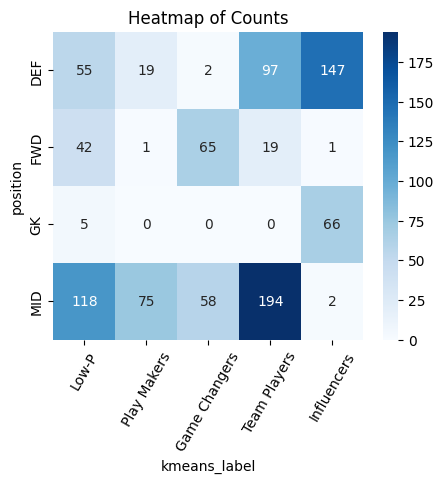

In [56]:
# Comparison against positions
count_matrix = pd.crosstab(all_player_df['position'], all_player_df['kmeans_label'])

fig, ax = plt.subplots() # Create a figure and an Axes object

sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Blues")
ax.set_xticklabels(['Low-P', 'Play Makers', 'Game Changers', 'Team Players', 'Influencers'], rotation = 60)
plt.title('Heatmap of Counts')
plt.show()

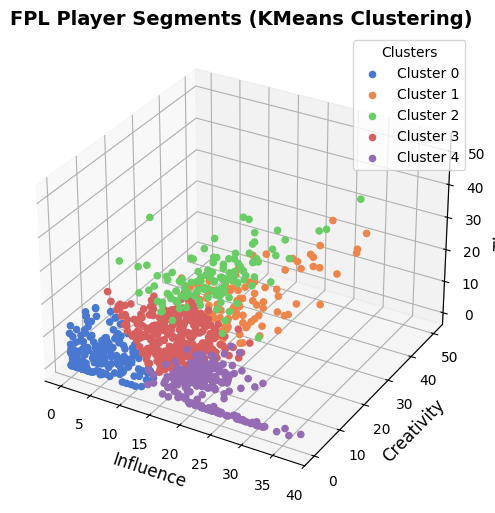

In [57]:
# Cluster visualization
kmeans_df = all_player_df[['creativity', 'influence', 'threat', 'kmeans_label']]

n_clusters = kmeans_df['kmeans_label'].nunique()
colors = sns.color_palette('muted', n_colors=n_clusters)

clusters = np.sort(kmeans_df['kmeans_label'].unique())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# scatter points cluster by cluster
for cluster, color in zip(clusters, colors):
    cluster_points = kmeans_df[kmeans_df['kmeans_label'] == cluster]
    ax.scatter(cluster_points['influence'],
               cluster_points['creativity'],
               cluster_points['threat'],
               color=color,
               s=20, alpha=1, label=f"Cluster {cluster}")

# add legend
ax.legend(title="Clusters")
ax.set_xlabel("Influence", fontsize=12)
ax.set_ylabel("Creativity", fontsize=12)
ax.set_zlabel("Threat", fontsize=12)
ax.set_title("FPL Player Segments (KMeans Clustering)", fontsize=14, fontweight="bold")

plt.show()

### **GMM**

Why?

K-Means --
Fast, easy to understand, works well when clusters are round and equally sized.

Cons:
Assumes clusters are spherical and same size → struggles if clusters have different shapes or densities.
Hard assignment → each player is forced into one cluster, even if they’re on the border.
Sensitive to outliers → one weird player can pull a centroid.


Gaussian Mixture Model (GMM)
Each cluster is a “soft blob” shaped by a Gaussian (ellipse). Each player gets a probability of belonging to each cluster.

Pros:
Captures elliptical clusters better.
Gives soft assignment -- will allow for recommendations such as  “Cole Palmer is 60% in cluster 3, 40% in cluster 1”).
More flexible when clusters overlap.

Cons:
Slower than K-means.
Can overfit if you allow too many clusters.

In [59]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [60]:
X = player_ict.loc[:, ['creativity','influence','threat']].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(966, 3)

In [61]:
gmm = GaussianMixture(n_components=5, random_state=1)
gmm_df = pd.DataFrame(gmm.fit_predict(X), columns = ['cluster'])

gmm_result_df = pd.concat([player_ict, gmm_df], axis=1)
gmm_result_df['cluster_prob'] = gmm.predict_proba(X).max(axis=1)

In [62]:
## Finding second best clusters

prob_array = gmm.predict_proba(X)

two_clusters = []
for i in range(len(prob_array)):
    best_cluster = np.argsort(prob_array[i])[-1]
    second_best_cluster = np.argsort(prob_array[i])[-2]
    best_cluster_p = prob_array[i][best_cluster]
    second_cluster_p = prob_array[i][second_best_cluster]

    two_clusters.append([int(best_cluster), float(best_cluster_p), int(second_best_cluster), float(second_cluster_p)])

two_clusters_df = pd.DataFrame(two_clusters, columns = ['gmm_cluster', 'gmm_cluster_prob', 'gmm_sec_cluster', 'gmm_sec_cluster_prob'])

In [63]:
gmm_result_df = pd.concat([player_ict, two_clusters_df], axis=1)

In [65]:
gmm_result_df['gmm_cluster_prob'] = gmm_result_df['gmm_cluster_prob'].round(2)
gmm_result_df['gmm_sec_cluster_prob'] = gmm_result_df['gmm_sec_cluster_prob'].round(2)
gmm_result_df['kmeans_label'] = all_player_df['kmeans_label']
gmm_result_df.head()

,name,position,creativity,influence,threat,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob,kmeans_label
0,Aaron Cresswell,DEF,21.377369,14.775103,2.384932,1,0.99,3,0.01,1
1,Aaron Hickey,DEF,4.736939,9.441390,4.212027,3,0.59,1,0.23,0
2,Aaron Ramsdale,GK,0.001370,24.865753,0.000000,4,1.00,3,0.00,4
3,Aaron Ramsey,MID,3.175096,5.233333,6.306513,1,0.64,2,0.35,0
4,Aaron Wan-Bissaka,DEF,13.232237,20.712901,5.254687,3,0.98,1,0.02,3


In [71]:
# add points and value metrics
gmm_all_player_df = pd.concat([gmm_result_df, points_df[['total_points', 'total_minutes', 'avg_value_in_pounds']]], axis = 1)
gmm_all_player_df.loc[:,'points_per_minute'] = (all_player_df.loc[:,'total_points']/all_player_df.loc[:,'total_minutes']).astype(float).round(3)
gmm_all_player_df.loc[:,'points_per_pound'] = (all_player_df.loc[:,'total_points']/all_player_df.loc[:,'avg_value_in_pounds']).astype(float).round(3)
gmm_all_player_df.head()

,name,position,creativity,influence,threat,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
0,Aaron Cresswell,DEF,21.377369,14.775103,2.384932,1,0.99,3,0.01,1,116,3398,4.4,0.034,26.364
1,Aaron Hickey,DEF,4.736939,9.441390,4.212027,3,0.59,1,0.23,0,73,2561,4.8,0.029,15.208
2,Aaron Ramsdale,GK,0.001370,24.865753,0.000000,4,1.00,3,0.00,4,254,6570,4.7,0.039,54.043
3,Aaron Ramsey,MID,3.175096,5.233333,6.306513,1,0.64,2,0.35,0,18,522,5.0,0.034,3.600
4,Aaron Wan-Bissaka,DEF,13.232237,20.712901,5.254687,3,0.98,1,0.02,3,231,6294,4.4,0.037,52.500


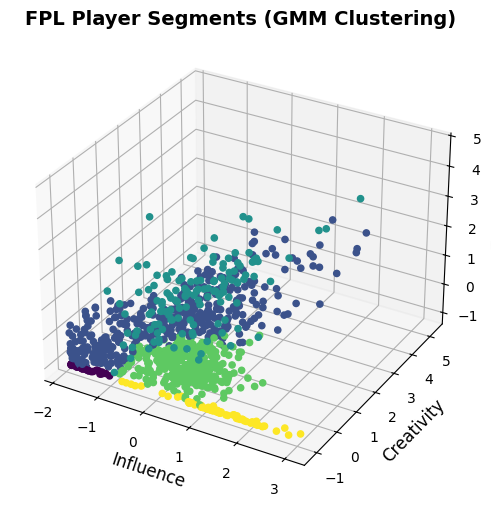

In [72]:
# Visually evaluating the clusters
df_x = pd.DataFrame(X, columns = ['creativity','influence','threat'])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df_x['influence'], df_x['creativity'], df_x['threat'], c=gmm_df['cluster'], cmap='viridis', s=20, alpha =1)

ax.set_xlabel("Influence", fontsize=12)
ax.set_ylabel("Creativity", fontsize=12)
ax.set_zlabel("Threat", fontsize=12)
ax.set_title("FPL Player Segments (GMM Clustering)", fontsize=14, fontweight="bold")


plt.show()

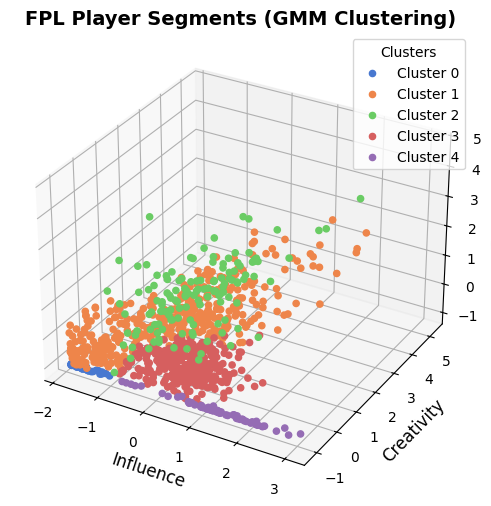

In [73]:
# Another one -- to show differences from Kmeans
df_x = pd.DataFrame(X, columns = ['creativity','influence','threat'])
n_clusters = gmm_df['cluster'].nunique()
colors = sns.color_palette('muted', n_colors=n_clusters)

clusters = np.sort(gmm_df['cluster'].unique())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# scatter points cluster by cluster
for cluster, color in zip(clusters, colors):
    cluster_points = df_x[gmm_df['cluster'] == cluster]
    ax.scatter(cluster_points['influence'],
               cluster_points['creativity'],
               cluster_points['threat'],
               color=color,
               s=20, alpha=1, label=f"Cluster {cluster}")

# add legend
ax.legend(title="Clusters")
ax.set_xlabel("Influence", fontsize=12)
ax.set_ylabel("Creativity", fontsize=12)
ax.set_zlabel("Threat", fontsize=12)
ax.set_title("FPL Player Segments (GMM Clustering)", fontsize=14, fontweight="bold")

plt.show()

In [76]:
## Checking new clusters
gmm_all_player_df[(gmm_all_player_df['gmm_cluster'] == 1)].sort_values(by = 'total_points', ascending = False).head(5)

,name,position,creativity,influence,threat,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
122,Bukayo Saka,MID,35.015187,28.571583,35.731789,1,1.00,2,0.00,1,549,7770,9.0,0.071,61.000
612,Martin Ødegaard,MID,36.661142,24.374755,22.065471,1,1.00,2,0.00,1,511,8477,7.8,0.060,65.513
117,Bruno Borges Fernandes,MID,43.731048,29.317619,21.495048,1,1.00,2,0.00,1,495,9189,8.8,0.054,56.250
856,Son Heung-min,MID,25.862267,23.038583,28.347199,1,0.99,2,0.01,2,481,7765,10.4,0.062,46.250
170,Cole Palmer,MID,32.841247,33.324350,29.780355,1,1.00,2,0.00,1,475,6078,7.7,0.078,61.688


In [75]:
gmm_all_player_df[(gmm_all_player_df['gmm_cluster'] == 2) & (gmm_all_player_df['total_minutes']>4000)].sort_values(by = 'total_points', ascending = False).head(5)

,name,position,creativity,influence,threat,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
669,Mohamed Salah,MID,28.637188,35.369270,49.673476,2,1.00,1,0.00,2,789,9105,13.1,0.087,60.229
269,Erling Haaland,FWD,11.870606,35.519886,51.554245,2,1.00,1,0.00,2,670,8056,13.7,0.083,48.905
729,Ollie Watkins,FWD,12.850440,25.060899,36.893156,2,1.00,1,0.00,2,580,8854,8.3,0.066,69.880
415,Jarrod Bowen,MID,18.164481,23.395716,31.851707,2,0.96,1,0.04,2,519,9198,7.7,0.056,67.403
29,Alexander Isak,FWD,15.163099,29.621469,38.217642,2,1.00,1,0.00,2,480,6428,8.0,0.075,60.000


In [77]:
# check inverted full backs
mask = (gmm_all_player_df['name'] == 'Trent Alexander-Arnold') | (gmm_all_player_df['name'] == 'Reece James') | (gmm_all_player_df['name'] == 'João Cancelo')
gmm_all_player_df[mask]

,name,position,creativity,influence,threat,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob,kmeans_label,total_points,total_minutes,avg_value_in_pounds,points_per_minute,points_per_pound
478,João Cancelo,DEF,16.944226,17.176277,16.426551,1,0.94,2,0.06,1,73,1273,7.2,0.057,10.139
774,Reece James,DEF,20.046114,17.085009,7.194475,1,0.96,3,0.03,1,109,2715,5.3,0.040,20.566
899,Trent Alexander-Arnold,DEF,33.754430,23.278998,7.991833,1,1.00,3,0.00,1,422,7347,7.5,0.057,56.267


In [78]:
# Example -- good

gmm_all_player_df[gmm_all_player_df['name'] == 'Son Heung-min'][['name', 'position', 'kmeans_label', 'gmm_cluster', 'gmm_cluster_prob', 'gmm_sec_cluster', 'gmm_sec_cluster_prob']]

,name,position,kmeans_label,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob
856,Son Heung-min,MID,2,1,0.99,2,0.01


In [79]:
# Example -- good
mask = (gmm_all_player_df['name'] == 'João Filipe Iria Santos Moutinho') | (gmm_all_player_df['name'] == 'Oscar Bobb') | (gmm_all_player_df['name'] == 'Kiernan Dewsbury-Hall')
gmm_all_player_df[mask][['name', 'position', 'kmeans_label', 'gmm_cluster', 'gmm_cluster_prob', 'gmm_sec_cluster', 'gmm_sec_cluster_prob']]

,name,position,kmeans_label,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob
479,João Filipe Iria Santos Moutinho,MID,3,1,0.95,3,0.05
524,Kiernan Dewsbury-Hall,MID,3,1,0.91,3,0.08
738,Oscar Bobb,MID,3,1,0.97,3,0.02


In [80]:
# Example -- debatable
gmm_all_player_df[gmm_all_player_df['name'] == 'Virgil van Dijk'][['name', 'position', 'kmeans_label', 'gmm_cluster', 'gmm_cluster_prob', 'gmm_sec_cluster', 'gmm_sec_cluster_prob']]

,name,position,kmeans_label,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob
915,Virgil van Dijk,DEF,4,3,0.99,2,0.01


In [81]:
# Example -- good
gmm_all_player_df[gmm_all_player_df['name'] == 'Leandro Trossard'][['name', 'position', 'kmeans_label', 'gmm_cluster', 'gmm_cluster_prob', 'gmm_sec_cluster', 'gmm_sec_cluster_prob']]

,name,position,kmeans_label,gmm_cluster,gmm_cluster_prob,gmm_sec_cluster,gmm_sec_cluster_prob
537,Leandro Trossard,MID,2,2,0.56,1,0.44


### **Comparison**

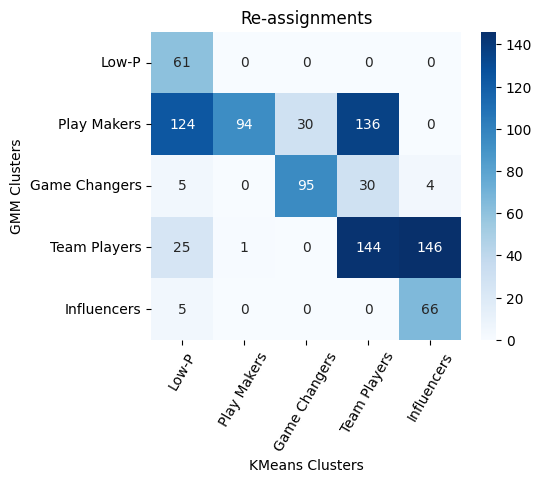

In [88]:
count_matrix = pd.crosstab(gmm_all_player_df['gmm_cluster'], gmm_all_player_df['kmeans_label'])


fig, ax = plt.subplots() # Create a figure and an Axes object

sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Blues")
ax.set_xticklabels(['Low-P', 'Play Makers', 'Game Changers', 'Team Players', 'Influencers'], rotation = 60)
ax.set_yticklabels(['Low-P', 'Play Makers', 'Game Changers', 'Team Players', 'Influencers'], rotation = 0)

ax.set_title('Re-assignments')
ax.set_xlabel('KMeans Clusters')
ax.set_ylabel('GMM Clusters')

plt.show()

In [89]:
print('Sum:', count_matrix.sum().sum())
count_matrix

Sum: 966


kmeans_label,0,1,2,3,4
gmm_cluster,,,,,
0,61,0,0,0,0
1,124,94,30,136,0
2,5,0,95,30,4
3,25,1,0,144,146
4,5,0,0,0,66


In [ ]:
# Fin